# Defining a total-field scattered-field (TFSF) plane wave source

This tutorial demonstrates the use of the [total-field scattered-field (TFSF) source](../api/_autosummary/tidy3d.TFSF.html) in `Tidy3D`.

The TFSF source allows specifying a box region into which a plane wave is injected. Fields inside this region can be interpreted as the superposition of the incident field and the scattered field due to any scatterers present in the simulation domain. The fields at the edges of the TFSF box are modified at each time step such that the incident field is cancelled out, so that all fields _outside_ the TFSF box are scattered fields only. This is useful in scenarios where one is interested in computing scattered fields only, for example when computing scattered cross sections of various objects. For an application example of radar cross section calculation using the TFSF technique, see [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Near2FarSphereRCS/).

In this notebook, various situations in which the TFSF source can be applied will be discussed through several examples, including the use of finite- or infinite-extent TFSF regions, angled plane wave injection, and layered substrates.

Note that unlike standard `Tidy3D` [PlaneWave sources](../api/_autosummary/tidy3d.PlaneWave.html), the [TFSF source](../api/_autosummary/tidy3d.TFSF.html) injects $1 \mathrm{W}\mu\mathrm{m}^{-2}$ of power in the TFSF source injection axis (note: this is **different** from the direction of propagation of the plane wave for angled incidence). This allows computing scattering and absorption cross sections without the need for additional normalization. For example, see [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Near2FarSphereRCS/) for radar cross section validation, and [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/PlasmonicNanoparticle/) for absorption by a plasmonic nanoparticle.

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web


### Simulation setup
Here we define the basic simulation parameters that will be used throughout this notebook.

In [2]:
# basic simulation parameters
sim_size = (6, 6, 8)  # um
wavelength = 1.0  # um
f0 = td.C_0 / wavelength  # Hz
fwidth = f0 / 60.0  # Hz
run_time = 20.0 / fwidth  # s

# grid resolution
cells_per_wvl = 10

# time dependence of the sources used in this notebook
source_time = td.GaussianPulse(freq0=f0, fwidth=fwidth)

# simulation grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=cells_per_wvl)

# boundary conditions: PML on all sides
boundary_spec = td.BoundarySpec.all_sides(td.PML())


### Source definition

We'll define a TFSF source region with angled injection similarly to the way in which any source in `Tidy3D` is defined.

In [3]:
# make the TFSF source specifying angled injection of a plane wave
source = td.TFSF(
    center=(0, 0, 0),
    size=(4, 3, 4),
    source_time=source_time,
    injection_axis=2,  # inject along the z axis...
    direction="+",  # ...in the positive direction, i.e. along z+
    name="tfsf1",
    pol_angle=0,
    angle_theta=np.pi / 6,  # with respect to the injection plane's normal vector
    angle_phi=np.pi / 5,  # with respect to the injection plane's normal vector
)


### Monitor definition
We'll define a set of monitors to
- measure the flux that is injected into the simulation and make sure it is properly normalized,
- measure the flux outside the TFSF region to make sure the incident field does not escape out side the TFSF region, and,
- visualize the fields on cross sectional cuts through the simulation domain.

In [4]:
# make a box flux monitor surrounding the source to measure the flux escaping the TFSF box
monitor_out = td.FluxMonitor(
    center=source.center,
    size=[size * 1.2 for size in source.size],
    freqs=[f0],
    name=f"flux_out",
)

# make a surface flux monitor across the simulation domain to measure the total injected flux
monitor_inj = td.FluxMonitor(
    center=source.center,
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name=f"flux_inj",
)

# make field monitors along each cardinal plane to look at the fields
monitor_freq_xy = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name="freq_xy",
)

monitor_freq_xz = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, 0, td.inf],
    freqs=[f0],
    name="freq_xz",
)

monitor_freq_yz = td.FieldMonitor(
    center=[0, 0, 0],
    size=[0, td.inf, td.inf],
    freqs=[f0],
    name="freq_yz",
)

# collect all monitors together
monitors = [monitor_out, monitor_inj, monitor_freq_xy, monitor_freq_xz, monitor_freq_yz]


### Make simulation

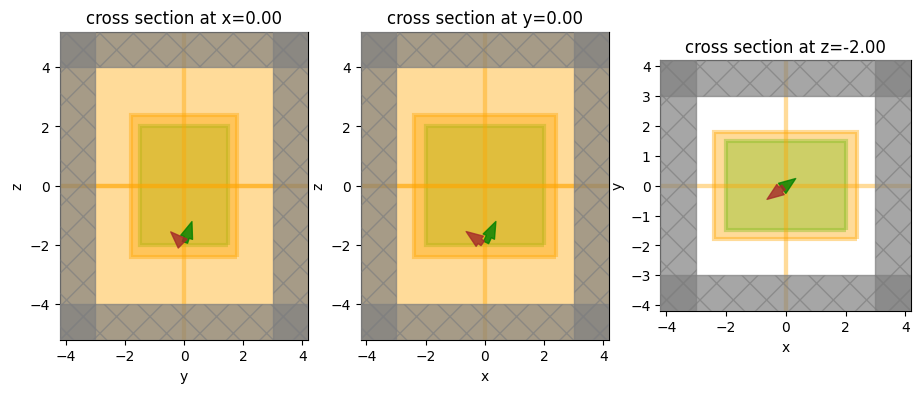

In [5]:
# make the simulation instance
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    medium=td.Medium(),  # air is the background medium
    structures=[],  # no structures
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
)

# visualize and check that everything was defined as expected
_, ax = plt.subplots(1, 3, figsize=(11, 4))
sim.plot(x=0, ax=ax[0])
sim.plot(y=0, ax=ax[1])
sim.plot(z=source.center[2] - source.size[2] / 2, ax=ax[2])
plt.show()


### Run the simulation

In [6]:
sim_data = web.run(sim, task_name="tfsf1", path="data/tfsf1.hdf5", verbose=True)


00:49:30 PST Created task 'tfsf1' with task_id                                  
             'fdve-1969ec58-033c-4fb5-a732-3cccd73442d2' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=858689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=76658;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\taskId]8;;\]8;id=858689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\=]8;;\]8;id=645002;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\fdve]8;;\]8;id=858689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\-1969ec58-033]8;;\
             ]8;id=858689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\c-4fb5-a732-3cccd73442d2']8;;\.

Output()

00:49:31 PST status = queued

Output()

00:49:37 PST status = preprocess

00:49:39 PST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

00:49:45 PST early shutoff detected at 8%, exiting.

             status = postprocess

Output()

00:49:47 PST status = success

             View simulation result at                                          
             ]8;id=372539;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=417278;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\taskId]8;;\]8;id=372539;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\=]8;;\]8;id=83792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\fdve]8;;\]8;id=372539;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\-1969ec58-033]8;;\
             ]8;id=372539;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1969ec58-033c-4fb5-a732-3cccd73442d2\c-4fb5-a732-3cccd73442d2']8;;\.

Output()

00:49:48 PST loading simulation from data/tfsf1.hdf5

### Flux results
If $1 \mathrm{W}\mu\mathrm{m}^{-2}$ is injected by the source, then the total injected flux captured should equal the area of the injection surface. To check that this is the case, we divide the computed injected flux by the area of the injection surface, and expect to obtain $1 \mathrm{W}\mu\mathrm{m}^{-2}$. We notice that the actual number is close to 1, but only within 1.5% accuracy. The reason for this is that the TFSF box actually snaps to the nearest FDTD grid cells. So, the actual area over which the source is injected is slightly different from the analytical area computed using `source.size`.

We notice that the flux escaping the box is about ten orders of magnitude lower than the injected flux, and therefore negligible, as expected.

In [7]:
# print the escaped and injected flux
print(
    "flux_inj per unit area: ",
    sim_data[f"flux_inj"].flux.values[0] / source.size[0] / source.size[1],
)
print("flux_box: ", sim_data[f"flux_out"].flux.values[0])


flux_inj per unit area:  1.0162611802419026
flux_box:  4.937256e-10


### Field plots
Here we'll visualize the frequency-domain fields and check that the plane wave is injected at the expected angle inside the TFSF box. As shown in the figures, the injected fields look correct inside the TFSF box, and are zero outside the box because there are no scatterers in this example.

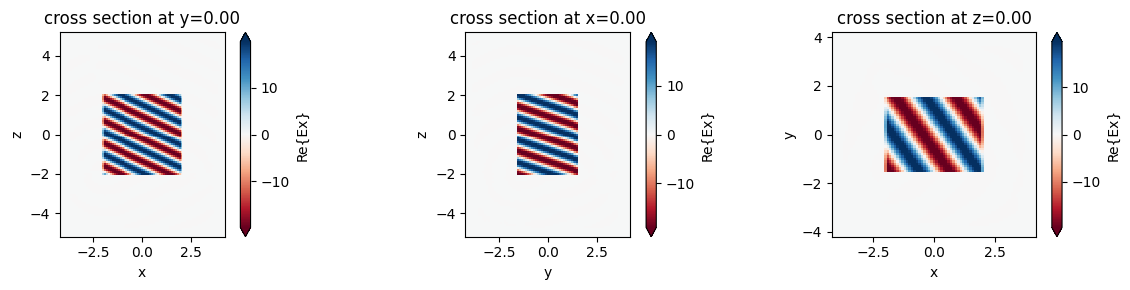

In [8]:
# helper plot the fields for each cross section of the simulation for given simulation data
def plot_results_freq(sim_data, field_name="Ex", val="real"):
    """Helper for plotting frequency domain fields."""

    _, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))

    sim_data.plot_field(
        field_monitor_name="freq_xz", field_name=field_name, val=val, f=f0, ax=ax1
    )
    sim_data.plot_field(
        field_monitor_name="freq_yz", field_name=field_name, val=val, f=f0, ax=ax2
    )
    sim_data.plot_field(
        field_monitor_name="freq_xy", field_name=field_name, val=val, f=f0, ax=ax3
    )
    plt.show()


plot_results_freq(sim_data, field_name="Ex", val="real")


### Infinite slab
We can also make the TFSF box a slab which is infinite in the transverse directions ($x$ and $y$ in this example). However, in this case we must ensure that the boundary conditions in those directions are compatible with the injected plane wave. For angled incidence, this implies that Bloch periodic boundaries ([BlochBoundary](../api/_autosummary/tidy3d.BlochBoundary.html)) must be used along $x$ and $y$. For normal incidence, either standard [Periodic](../api/_autosummary/tidy3d.Periodic.html) or Bloch boundaries can be used.

**Important**: the TFSF box must not touch or protrude beyond the simulation domain along the injection axis. In this example, the TFSF box must not touch or go past the simulation domain in the $-z$ or $+z$ directions, because our `injection_axis` is `2`, i.e. $z$.

In [9]:
# make a TFSF source infinite along x and y
source = td.TFSF(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 4),
    source_time=source_time,
    injection_axis=2,  # inject along the z axis...
    direction="+",  # ...in the positive direction, i.e. along z+
    name="tfsf2",
    pol_angle=0,
    angle_theta=np.pi / 4,
    angle_phi=np.pi / 4,
)

# specify boundaries compatible with this source
boundary_spec = td.BoundarySpec(
    x=td.Boundary.bloch_from_source(source=source, domain_size=sim_size[0], axis=0),
    y=td.Boundary.bloch_from_source(source=source, domain_size=sim_size[1], axis=1),
    z=td.Boundary.pml(),
)

# make flux monitors above and below the source to measure the escaped flux
center = [source.center[0], source.center[1], source.center[2]]
center[source.injection_axis] += 1.2 * source.size[source.injection_axis] / 2.0
monitor_above = td.FluxMonitor(
    center=[
        source.center[0],
        source.center[1],
        source.center[2] + 1.2 * source.size[2] / 2.0,
    ],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name=f"flux_above",
)

center = [source.center[0], source.center[1], source.center[2]]
center[source.injection_axis] -= 1.2 * source.size[source.injection_axis] / 2.0
monitor_below = td.FluxMonitor(
    center=[
        source.center[0],
        source.center[1],
        source.center[2] - 1.2 * source.size[2] / 2.0,
    ],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name=f"flux_below",
)

# collect all the monitors together again
monitors = [
    monitor_above,
    monitor_below,
    monitor_inj,
    monitor_freq_xy,
    monitor_freq_xz,
    monitor_freq_yz,
]


### Make simulation

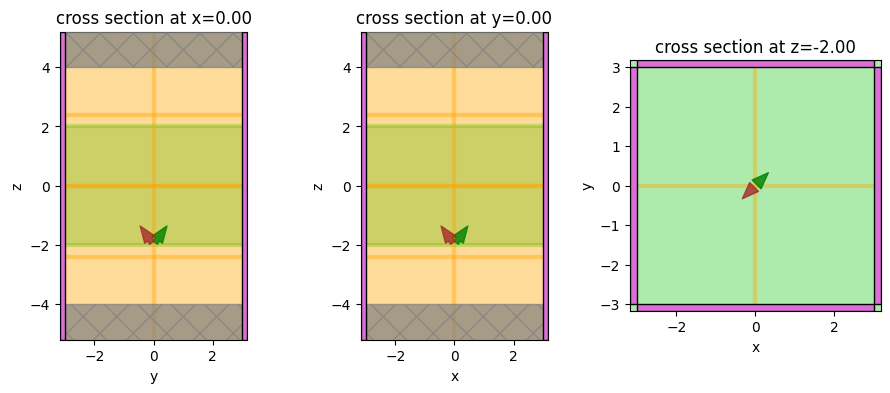

In [10]:
# update the simulation object with the new source, boundaries, and monitors
sim = sim.copy(
    update={
        "sources": [source],
        "boundary_spec": boundary_spec,
        "monitors": monitors,
    }
)

# visualize
_, ax = plt.subplots(1, 3, figsize=(11, 4))
sim.plot(x=0, ax=ax[0])
sim.plot(y=0, ax=ax[1])
sim.plot(z=source.center[2] - source.size[2] / 2, ax=ax[2])
plt.show()


### Run the simulation

In [11]:
sim_data = web.run(sim, task_name="tfsf2", path="data/tfsf2.hdf5", verbose=True)


00:49:49 PST Created task 'tfsf2' with task_id                                  
             'fdve-cb8dca32-326b-44f3-b800-e92df64390d9' and task_type 'FDTD'.

00:49:50 PST View task using web UI at                                          
             ]8;id=645588;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=305113;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\taskId]8;;\]8;id=645588;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\=]8;;\]8;id=203877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\fdve]8;;\]8;id=645588;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\-cb8dca32-326]8;;\
             ]8;id=645588;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\b-44f3-b800-e92df64390d9']8;;\.

Output()

00:49:51 PST status = queued

Output()

00:49:56 PST status = preprocess

00:49:58 PST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

00:50:04 PST early shutoff detected at 8%, exiting.

             status = postprocess

Output()

00:50:06 PST status = success

             View simulation result at                                          
             ]8;id=600198;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=750869;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\taskId]8;;\]8;id=600198;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\=]8;;\]8;id=784668;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\fdve]8;;\]8;id=600198;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\-cb8dca32-326]8;;\
             ]8;id=600198;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cb8dca32-326b-44f3-b800-e92df64390d9\b-44f3-b800-e92df64390d9']8;;\.

Output()

00:50:07 PST loading simulation from data/tfsf2.hdf5

### Flux results
Here, the flux injected by the source is extremely close to $1 \mathrm{W}\mu\mathrm{m}^{-2}$ as there are no finite-size effects at the source boundaries. As expected, the flux escaping above and below the TFSF slab is negligibly small.

In [12]:
# print the escaped and injected flux
print(
    "flux_inj per unit area: ",
    sim_data[f"flux_inj"].flux.values[0] / sim.size[0] / sim.size[1],
)  # using sim.size because the TFSF slab extends to sim edges
print("flux_above: ", sim_data[f"flux_above"].flux.values[0])
print("flux_below: ", sim_data[f"flux_below"].flux.values[0])


flux_inj per unit area:  0.9999941719902886
flux_above:  1.0999211e-08
flux_below:  -1.23833e-11


### Field plots
In plotting the fields, we can see that the plane wave is injected at the desired angle without leakage into the scattered-field region.

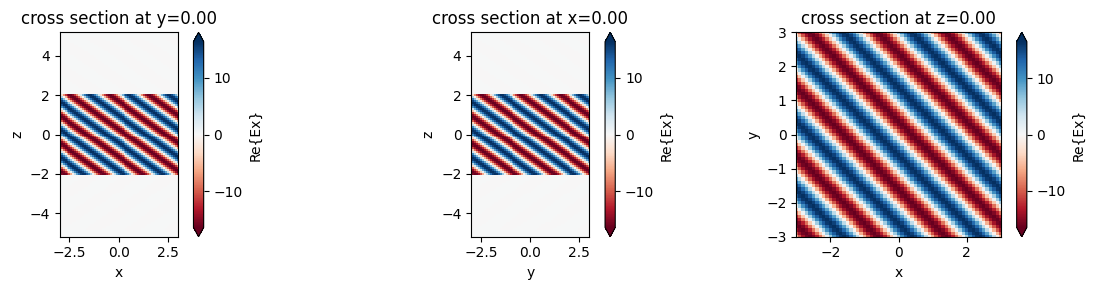

In [13]:
plot_results_freq(sim_data, field_name="Ex", val="real")


### TFSF source in a layered substrate
A TFSF source can be set up in a layered substrate as long as the following condition is satisfied: **all four side walls of the TFSF box must see the same material profile along the injection axis**. In other words, any scatterers in the domain must either:

 - intersect each of the 4 side walls of the TFSF box in exactly the same way, e.g., a layered substrate, or,
 
 - be entirely inside or entirely outside the TFSF box.

This example shows how to set up a TFSF source in a layered substrate.

In [14]:
# parameters of the layered substrate
epsrs = [4, 1.5, 5.5, 2.8]  # permittivities
zsizes = [0.3, 0.6, 0.7, 1.2]  # thicknesses
zpos = -1.5  # starting position of the first layer

# make the layer structures
layers = []
for idx, epsr in enumerate(epsrs):
    medium = td.Medium(permittivity=epsr)
    size = (td.inf, td.inf, zsizes[idx])
    center = (0, 0, zpos + zsizes[idx] / 2)
    layers.append(
        td.Structure(geometry=td.Box(center=center, size=size), medium=medium)
    )
    zpos += zsizes[idx]

# make a TFSF box
source = td.TFSF(
    center=(0, 0, 0),
    size=(4, 3, 4),
    source_time=source_time,
    injection_axis=2,  # inject along the z axis...
    direction="+",  # ...in the positive direction, i.e. along z+
    name="tfsf3",
    pol_angle=0,
    angle_theta=np.pi / 6,
    angle_phi=np.pi / 7,
)

# specify boundaries compatible with the source for the scattered fields to obey;
# note that the source plane goes through the first layer of the substrate,
# so we should use that medium when specifying the Bloch boundaries
boundary_spec = td.BoundarySpec(
    x=td.Boundary.bloch_from_source(
        source=source,
        domain_size=sim_size[0],
        axis=0,
        medium=td.Medium(permittivity=epsrs[0]),
    ),
    y=td.Boundary.bloch_from_source(
        source=source,
        domain_size=sim_size[1],
        axis=1,
        medium=td.Medium(permittivity=epsrs[0]),
    ),
    z=td.Boundary.pml(),
)

# reuse the monitors from the first simulation
monitors = [monitor_out, monitor_inj, monitor_freq_xy, monitor_freq_xz, monitor_freq_yz]


### Make simulation

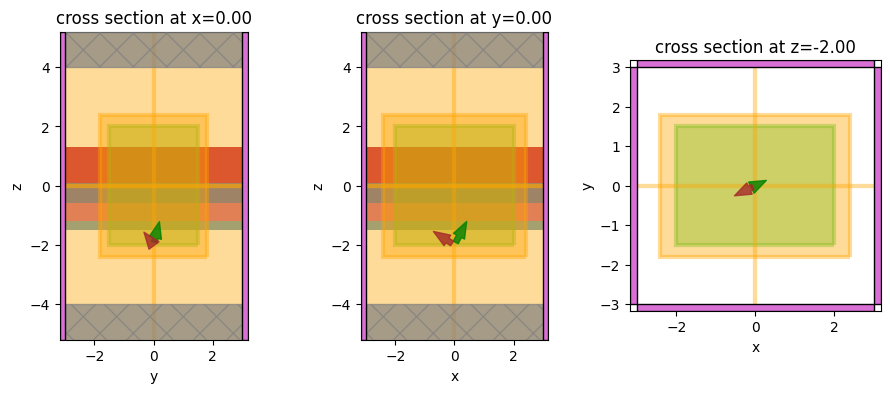

In [15]:
# update the simulation object with the new source, boundaries, monitors, and structures
sim = sim.copy(
    update={
        "sources": [source],
        "boundary_spec": boundary_spec,
        "monitors": monitors,
        "structures": layers,
    }
)

# visualize
_, ax = plt.subplots(1, 3, figsize=(11, 4))
sim.plot(x=0, ax=ax[0])
sim.plot(y=0, ax=ax[1])
sim.plot(z=source.center[2] - source.size[2] / 2, ax=ax[2])
plt.show()


### Run the simulation

In [16]:
sim_data = web.run(sim, task_name="tfsf3", path="data/tfsf3.hdf5", verbose=True)


00:50:09 PST Created task 'tfsf3' with task_id                                  
             'fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=862937;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=907085;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\taskId]8;;\]8;id=862937;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\=]8;;\]8;id=301254;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\fdve]8;;\]8;id=862937;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\-5a54a320-7e7]8;;\
             ]8;id=862937;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\c-4592-bc84-f0784aa01af3']8;;\.

Output()

00:50:10 PST status = queued

Output()

00:50:14 PST status = preprocess

00:50:16 PST Maximum FlexCredit cost: 0.083. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

00:50:24 PST early shutoff detected at 8%, exiting.

             status = postprocess

Output()

00:50:27 PST status = success

00:50:28 PST View simulation result at                                          
             ]8;id=191610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=847324;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\taskId]8;;\]8;id=191610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\=]8;;\]8;id=966433;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\fdve]8;;\]8;id=191610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\-5a54a320-7e7]8;;\
             ]8;id=191610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a54a320-7e7c-4592-bc84-f0784aa01af3\c-4592-bc84-f0784aa01af3']8;;\.

Output()

             loading simulation from data/tfsf3.hdf5

### Flux results
Despite the elaborate stack-up of dielectric layers considered above, we again see that the incident field is effectively confined within the TFSF box, while taking into account the presence of the layered substrate, with negligible leakage to the scattered field region.

In [17]:
# print the escaped flux
print("flux_box: ", sim_data[f"flux_out"].flux.values[0])


flux_box:  3.686509e-09


### Field plots
The frequency-domain field plots confirm that the incident field is injected at the expected angle, takes into account the layer interfaces, and remains confined to the total field region.

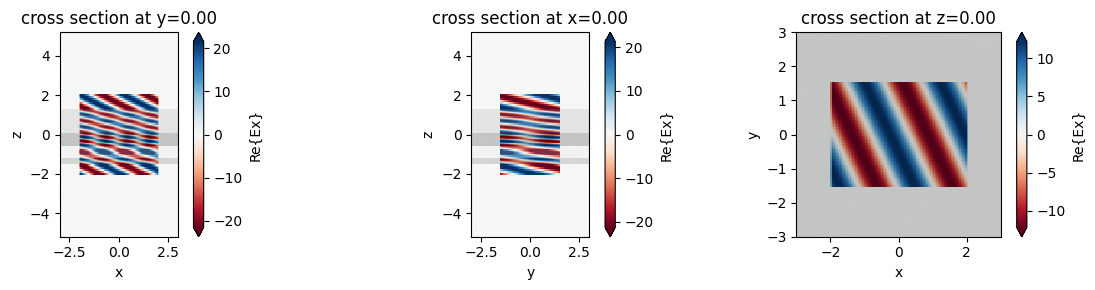

In [18]:
plot_results_freq(sim_data, field_name="Ex", val="real")


### Example with a scatterer
Finally, we'll simulate the presence of a scatterer inside the TFSF box, as would be the case in scattering cross section problems. To validate the result, we'll also simulate the same scatterer using a standard plane wave source, and then compute the scattered field by subtracting out the incident field manually. This will require an additional simulation of the same domain but without the scatterer, to compute the incident field. This example will demonstrate the usefulness of TFSF in obtaining scattered fields without the need to run two simulations.

In [19]:
# make a TFSF box
source = td.TFSF(
    center=(0, 0, 0.2),
    size=(5, 5, 3.5),
    source_time=source_time,
    injection_axis=2,  # inject along the z axis...
    direction="+",  # ...in the positive direction, i.e. along z+
    name="tfsf4",
    pol_angle=0,
)

# set up scatterers: two boxes and a sphere inside the TFSF box
box1 = td.Structure(
    geometry=td.Box(center=[0, 0, 0.3], size=[4, 4, 0.6]),
    medium=td.material_library["SiO2"]["Horiba"],
)

box2 = td.Structure(
    geometry=td.Box(center=[0, 0, 1], size=[3, 3, 0.8]),
    medium=td.material_library["SiN"]["Horiba"],
)

sphere = td.Structure(
    geometry=td.Sphere(center=[-1, 0, -0.8], radius=0.6),
    medium=td.Medium(permittivity=2.4),
)

# collect all objects
structures = [box1, box2, sphere]

# make a field monitor above the TFSF box to compare fields between the two cases
monitor_freq = td.FieldMonitor(
    center=[0, 0, 2.5],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name="freq",
)

# specify PML boundaries on all sides
boundary_spec = td.BoundarySpec.all_sides(td.PML())


#### Simulation with TFSF source

It is important to note that when a non-uniform grid is used in the directions transverse to the `injection_axis` of the TFSF source, the suppression of the incident field outside the TFSF box may not be as close to zero as in the case of a uniform grid. Because of this, Tidy3D issues a warning when nonuniform grid TFSF setup is detected. In some cases, however, the accuracy may be only weakly affected, and the warnings can be ignored. In this example, the presence of scatterers does cause the auto-generated FDTD grid to be non-uniform in the $x$ and $y$ directions, but as we'll see, the results are still in excellent agreement with the reference simulation. To force a uniform grid in the TFSF region and avoid the warnings, a mesh override structure can be used, as illustrated in our [nanoparticle scattering example](../notebooks/PlasmonicNanoparticle.html).

The presence of a non-uniform grid _along_ the `injection_axis` is not a problem.

00:50:30 PST WARNING: The grid is nonuniform along the 'x' axis, which may lead 
             to sub-optimal cancellation of the incident field in the           
             scattered-field region for the total-field scattered-field (TFSF)  
             source 'tfsf4'. For best results, we recommended ensuring a uniform
             grid in both directions tangential to the TFSF injection axis, 'z'.

             WARNING: Suppressed 1 WARNING message.                             

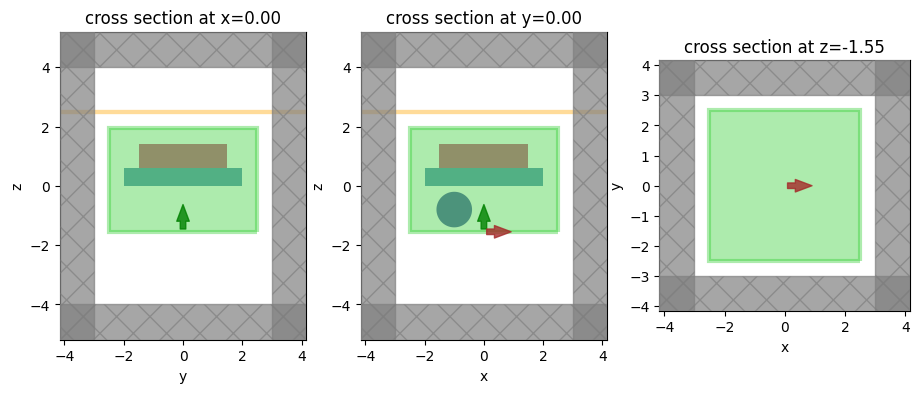

In [20]:
# make the TFSF simulation by updating the previous one with the new structures and monitor
sim = sim.copy(
    update={
        "boundary_spec": boundary_spec,
        "monitors": [monitor_freq],
        "structures": structures,
        "sources": [source],
    }
)

# visualize
_, ax = plt.subplots(1, 3, figsize=(11, 4))
sim.plot(x=0, ax=ax[0])
sim.plot(y=0, ax=ax[1])
sim.plot(z=source.center[2] - source.size[2] / 2, ax=ax[2])
plt.show()


#### Reference simulation

We will compare the results with a simulation that uses a regular plane wave source, where we compute scattered fields by also running an empty simulation and subtracting the results of the empty simulation from the results of the full one.

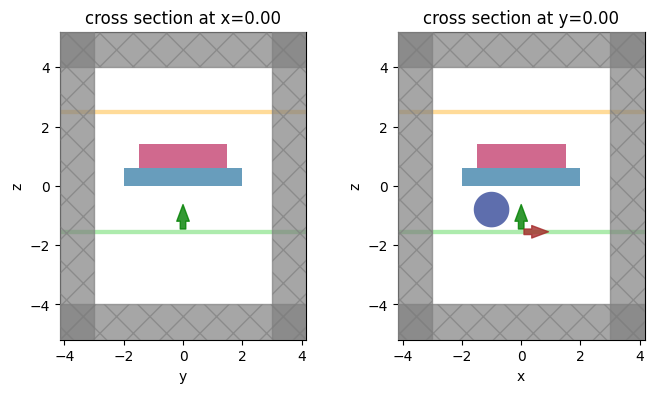

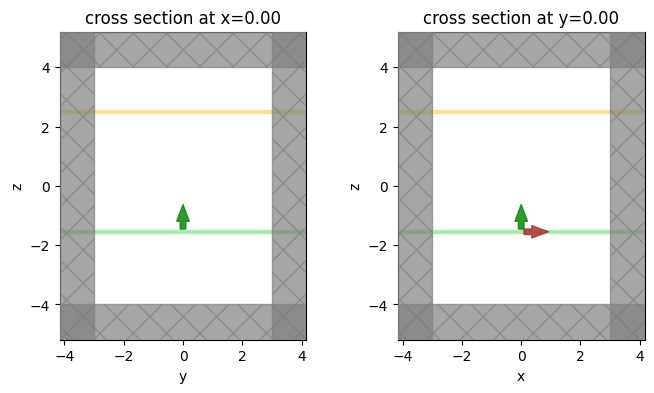

In [21]:
# make the two reference simulation with a standard plane wave source, one of them without the scatterer
source_planewave = td.PlaneWave(
    center=(0, 0, -1.55),
    size=(td.inf, td.inf, 0),
    source_time=source_time,
    direction="+",
    name="planewave",
    pol_angle=0,
)

sim_ref = sim.copy(
    update={
        "sources": [source_planewave],
    }
)

# for the empty simulation, we need to make sure the grid is identical to the one with objects,
# so we use override structures to create "phantoms" of the objects, so that the grid is generated
# as though the objects were there, even though they're not
grid_spec_empty = td.GridSpec.auto(
    min_steps_per_wvl=cells_per_wvl,
    override_structures=[box1, box2, sphere],
)

sim_ref_empty = sim.copy(
    update={
        "sources": [source_planewave],
        "structures": [],
        "grid_spec": grid_spec_empty,
    }
)

# visualize both simulations
_, ax = plt.subplots(1, 2, figsize=(8, 4))
sim_ref.plot(x=0, ax=ax[0])
sim_ref.plot(y=0, ax=ax[1])
plt.show()

_, ax = plt.subplots(1, 2, figsize=(8, 4))
sim_ref_empty.plot(x=0, ax=ax[0])
sim_ref_empty.plot(y=0, ax=ax[1])
plt.show()


### Run all three simulations

In [22]:
# TFSF simulation
sim_data = web.run(sim, task_name="tfsf4", path="data/tfsf4.hdf5")

# planewave simulation
sim_data_ref = web.run(sim_ref, task_name="planewave", path="data/planewave.hdf5")

# planewave simulation without objects
sim_data_ref_empty = web.run(
    sim_ref_empty, task_name="planewave_empty", path="data/planewave_empty.hdf5"
)


00:50:31 PST Created task 'tfsf4' with task_id                                  
             'fdve-2655e725-c85f-4637-b58d-dfa9d2241733' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=728007;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=908708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\taskId]8;;\]8;id=728007;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\=]8;;\]8;id=548781;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\fdve]8;;\]8;id=728007;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\-2655e725-c85]8;;\
             ]8;id=728007;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\f-4637-b58d-dfa9d2241733']8;;\.

Output()

00:50:32 PST status = queued

Output()

00:50:38 PST status = preprocess

00:50:39 PST Maximum FlexCredit cost: 0.028. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

00:50:47 PST early shutoff detected at 12%, exiting.

             status = postprocess

Output()

00:50:51 PST status = success

             View simulation result at                                          
             ]8;id=637943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=587505;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\taskId]8;;\]8;id=637943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\=]8;;\]8;id=1473;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\fdve]8;;\]8;id=637943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\-2655e725-c85]8;;\
             ]8;id=637943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2655e725-c85f-4637-b58d-dfa9d2241733\f-4637-b58d-dfa9d2241733']8;;\.

Output()

00:50:52 PST loading simulation from data/tfsf4.hdf5

             WARNING: The grid is nonuniform along the 'x' axis, which may lead 
             to sub-optimal cancellation of the incident field in the           
             scattered-field region for the total-field scattered-field (TFSF)  
             source 'tfsf4'. For best results, we recommended ensuring a uniform
             grid in both directions tangential to the TFSF injection axis, 'z'.

             WARNING: Suppressed 1 WARNING message.                             

             Created task 'planewave' with task_id                              
             'fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=950799;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=839466;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\taskId]8;;\]8;id=950799;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\=]8;;\]8;id=215943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\fdve]8;;\]8;id=950799;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\-e5c1c7d6-bdb]8;;\
             ]8;id=950799;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\9-4848-9ede-2532e7d41dff']8;;\.

Output()

00:50:53 PST status = queued

Output()

00:50:57 PST status = preprocess

00:50:58 PST Maximum FlexCredit cost: 0.028. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

00:51:05 PST early shutoff detected at 12%, exiting.

             status = postprocess

Output()

00:51:08 PST status = success

             View simulation result at                                          
             ]8;id=677683;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=70742;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\taskId]8;;\]8;id=677683;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\=]8;;\]8;id=86541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\fdve]8;;\]8;id=677683;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\-e5c1c7d6-bdb]8;;\
             ]8;id=677683;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e5c1c7d6-bdb9-4848-9ede-2532e7d41dff\9-4848-9ede-2532e7d41dff']8;;\.

Output()

             loading simulation from data/planewave.hdf5

00:51:09 PST Created task 'planewave_empty' with task_id                        
             'fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=350470;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=339054;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\taskId]8;;\]8;id=350470;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\=]8;;\]8;id=958364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\fdve]8;;\]8;id=350470;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\-0c48e8a6-306]8;;\
             ]8;id=350470;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\e-4bc9-8e3a-aadf40c70177']8;;\.

Output()

00:51:10 PST status = queued

Output()

00:51:13 PST status = preprocess

00:51:14 PST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

00:51:20 PST early shutoff detected at 8%, exiting.

             status = postprocess

Output()

00:51:22 PST status = success

00:51:23 PST View simulation result at                                          
             ]8;id=419129;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=120660;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\taskId]8;;\]8;id=419129;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\=]8;;\]8;id=933639;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\fdve]8;;\]8;id=419129;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\-0c48e8a6-306]8;;\
             ]8;id=419129;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0c48e8a6-306e-4bc9-8e3a-aadf40c70177\e-4bc9-8e3a-aadf40c70177']8;;\.

Output()

             loading simulation from data/planewave_empty.hdf5

For the reference simulation, compute the scattered fields by subtracting the results of the empty simulation.

In [23]:
# for the plane wave simulations, we need to manually compute the scattered fields
# by subtracting out the incident fields computed in the empty simulation
data_ref = sim_data_ref[monitor_freq.name]
data_ref_empty = sim_data_ref_empty[monitor_freq.name]

for field, field_empty in zip(
    data_ref.field_components.values(), data_ref_empty.field_components.values()
):
    field.values -= field_empty.values


### Plot and compare
Notice the excellent agreement in the scattered field distribution for the TFSF and reference cases. Note, however, that the field magnitudes are different in the two cases. The reason is that the sources are normalized differently, as discussed above.

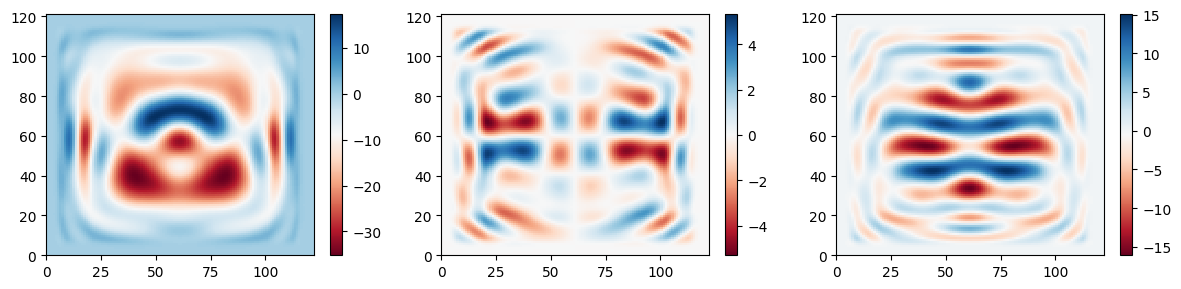

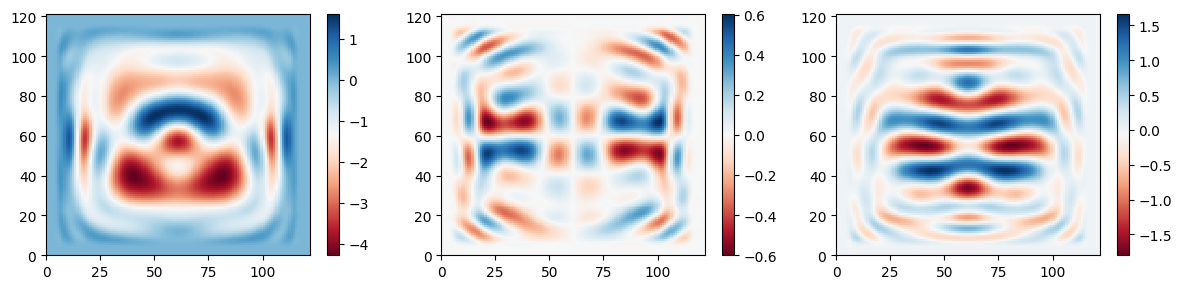

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))

im1 = ax1.pcolormesh(
    np.real(sim_data[monitor_freq.name].Ex.isel(z=0, f=0)), cmap="RdBu", shading="auto"
)
im2 = ax2.pcolormesh(
    np.real(sim_data[monitor_freq.name].Ey.isel(z=0, f=0)), cmap="RdBu", shading="auto"
)
im3 = ax3.pcolormesh(
    np.real(sim_data[monitor_freq.name].Ez.isel(z=0, f=0)), cmap="RdBu", shading="auto"
)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))

im1 = ax1.pcolormesh(np.real(data_ref.Ex.isel(z=0, f=0)), cmap="RdBu", shading="auto")
im2 = ax2.pcolormesh(np.real(data_ref.Ey.isel(z=0, f=0)), cmap="RdBu", shading="auto")
im3 = ax3.pcolormesh(np.real(data_ref.Ez.isel(z=0, f=0)), cmap="RdBu", shading="auto")
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

plt.show()
